This notebook demonstrates timeseries forecasting using RNNs, when it comes to predicting the milk sales regarding the last 12 months.

Each row in the datasets represents the sales on a monthly basis.

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from typing import List


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from dataclasses import dataclass, field

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GRU, LSTM, RNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import set_random_seed

<IPython.core.display.Javascript object>

In [4]:
sns.set_theme("notebook")

<IPython.core.display.Javascript object>

# Data

In [5]:
DATA_PATH_URL = "https://raw.githubusercontent.com/nachi-hebbar/Time-Series-Forecasting-LSTM/main/monthly_milk_production.csv"

df = pd.read_csv(DATA_PATH_URL, parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.index.freq = "MS"

<IPython.core.display.Javascript object>

In [6]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<IPython.core.display.Javascript object>

In [7]:
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='Date'>

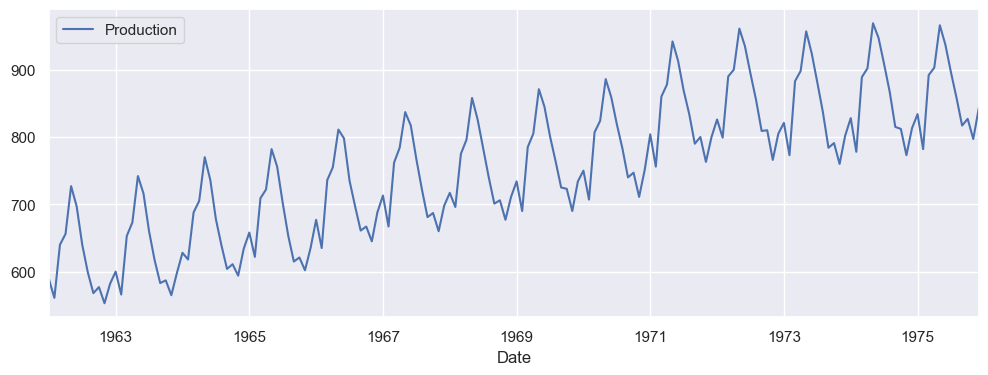

<IPython.core.display.Javascript object>

In [8]:
df.plot(figsize=(12, 4))

## Decompose

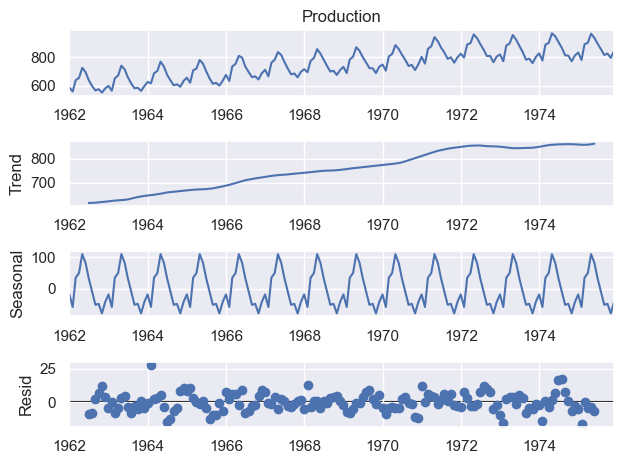

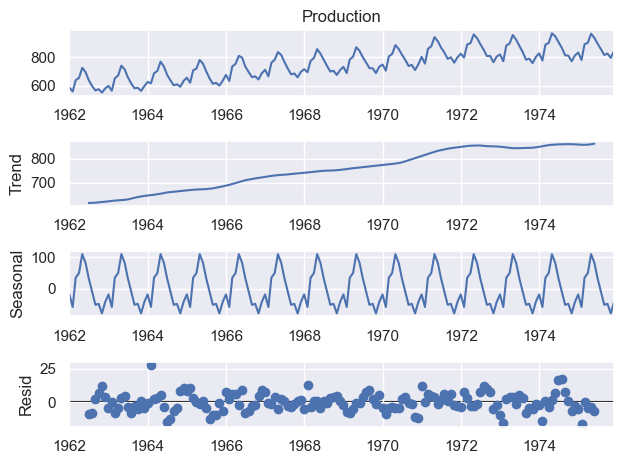

<IPython.core.display.Javascript object>

In [9]:
results = seasonal_decompose(df["Production"])
results.plot()

# Spit train, test sets

In [10]:
X_train = df.iloc[:156]
X_test = df.iloc[156:]

<IPython.core.display.Javascript object>

# Preprocessing

In [11]:
scaler = MinMaxScaler()

X_train_preprocessed = scaler.fit_transform(X_train)
X_test_preprocessed = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [12]:
X_train_preprocessed[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

<IPython.core.display.Javascript object>

In [13]:
N_INPUT = 12
BATCH_SIZE = 1
N_FEATURES = 1

time_series_generator = TimeseriesGenerator(
    data=X_train_preprocessed,
    targets=X_train_preprocessed,
    length=N_INPUT,
    batch_size=BATCH_SIZE,
)

<IPython.core.display.Javascript object>

## Model

In [14]:
set_random_seed(42)
model = Sequential(
    [
        GRU(units=100, activation="relu", input_shape=(N_INPUT, N_FEATURES)),
        Dense(units=1),
    ]
)

OPTIMIZER = Adam(learning_rate=0.001)
LOSS = "mse"
METRICS = ["mse"]

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

<IPython.core.display.Javascript object>

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               30900     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [16]:
early_stopping = EarlyStopping(monitor="mse")
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="mse")

CALLBACKS = [early_stopping, reduce_lr_on_plateau]

<IPython.core.display.Javascript object>

In [17]:
EPOCHS = 50

model.fit(time_series_generator, epochs=EPOCHS)

Epoch 1/50
144/144 [==============================] - 2s 3ms/step - loss: 0.0517 - mse: 0.0517
Epoch 2/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0208 - mse: 0.0208
Epoch 3/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0170 - mse: 0.0170
Epoch 4/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0148 - mse: 0.0148
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132
Epoch 6/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123
Epoch 7/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092
Epoch 9/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091
Epoch 10/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 0.0085
Epoch 11/50
144/144 [============================

<IPython.core.display.Javascript object>

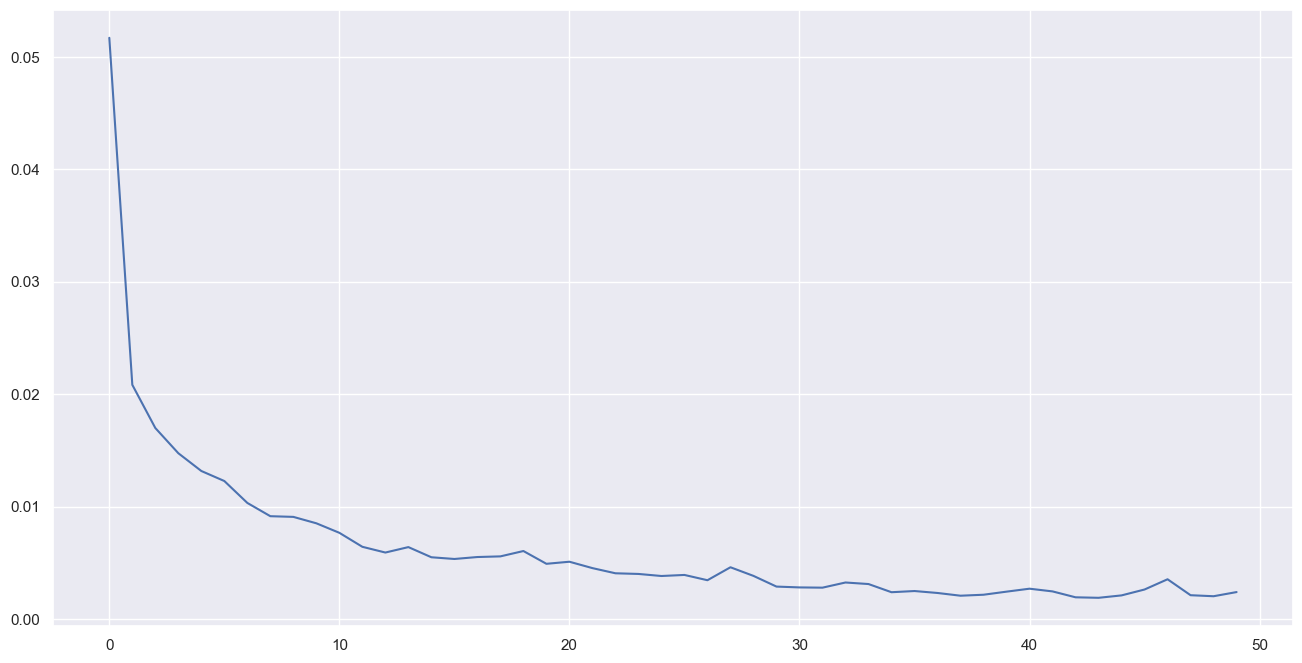

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

loss = model.history.history["loss"]
ax.plot(loss)

# Predictions

In [19]:
@dataclass
class ForecastingRunner:
    model: Sequential
    n_input: int
    n_features: int
    n_predictions: int

    def run(self, seq: np.ndarray) -> List:
        assert (
            len(seq) >= self.n_input
        ), f"Sequence size {len(seq)} must be >= input length {self.n_input}"

        self.input = seq.copy()[: self.n_input]
        y_pred = []

        for _ in range(self.n_predictions):
            self.reshape_input()
            input_prediction = self.model.predict(self.input)
            y_pred.append(input_prediction)
            self.update_input(input_prediction)

        return y_pred

    def update_input(self, input_prediction):
        self.input = np.delete(self.input, 0)
        self.input = np.append(self.input, input_prediction)

    def reshape_input(self):
        self.input = self.input.reshape(1, self.n_input, self.n_features)

<IPython.core.display.Javascript object>

In [21]:
forecasting_runner = ForecastingRunner(
    model, n_input=N_INPUT, n_predictions=X_test.shape[0], n_features=N_FEATURES
)

y_pred = forecasting_runner.run(seq=X_train_preprocessed[-N_INPUT:])

1/1 [==============================] - 0s 17ms/step


<IPython.core.display.Javascript object>

In [22]:
y_pred_inversed_transformed = scaler.inverse_transform(
    np.array(y_pred).reshape(1, -1)
).flatten()

<IPython.core.display.Javascript object>

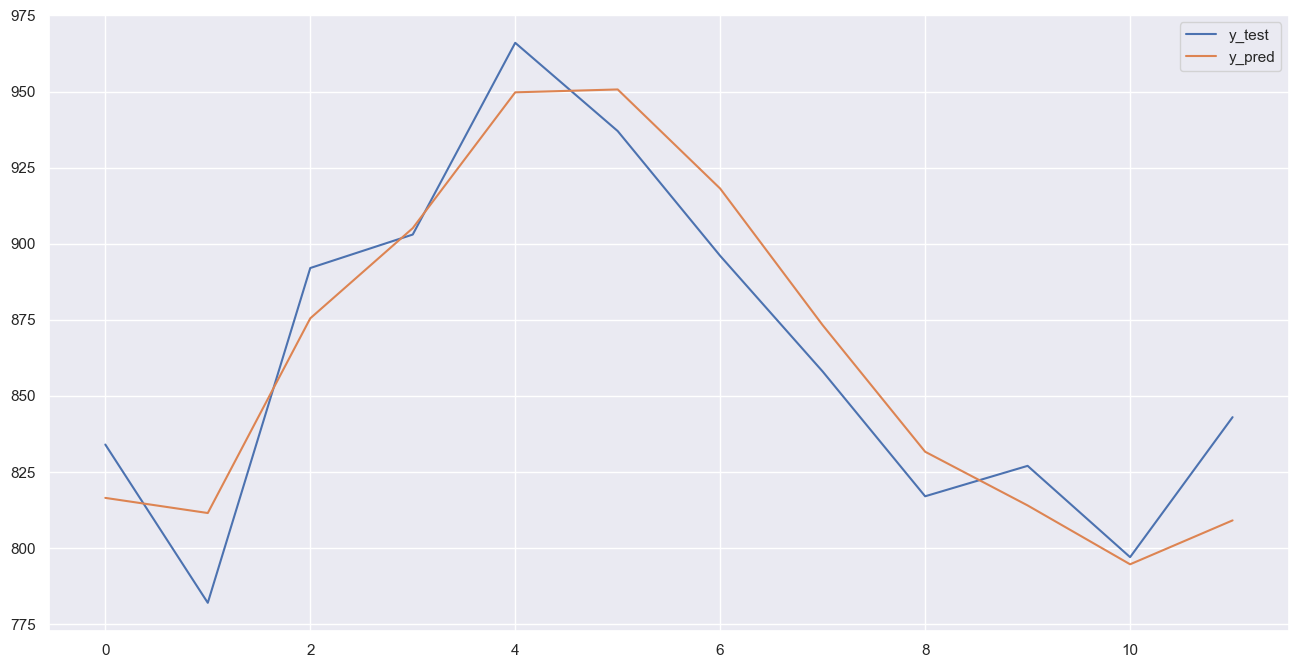

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))


ax.plot(X_test["Production"].values, label="y_test")
ax.plot(y_pred_inversed_transformed, label="y_pred")
plt.legend()